In [44]:
import xxhash
import random
import statistics
import sys
from random import uniform
import matplotlib.pyplot as plt
import numpy as np

scale = 1.0/(2**32)



class Hash:
    def generate_seed():
        return random.randint(0,2**32)
    
    def __init__(self, a):
        self.a=a
        
    def hash(self, x):
        return xxhash.xxh32_intdigest(x.to_bytes(4, 'little'), seed=self.a)*scale

    def sample_count(self, l,t):
        return sum(1 for x in l if self.hash(x) < t)

        

rands=list()
a = Hash.generate_seed()
h = Hash(a)

s = list(range(0,100000))
s+= list(range(120000, 130000))

print("n, sample count(.1)", len(s), h.sample_count(s,.1))
for i in s:
    rands.append(h.hash(i))

print("seeds, test mean ", a, statistics.mean(rands))
    
#a = list(range(0,10000))
#random.shuffle(a)
#h = map(hash_normalized, a)


#print(max(h))



n, sample count(.1) 110000 10978
seeds, test mean  305395834 0.4999161087783964


20000 10000 7000 23000 0.01
avg correction 1.0119527044382801
simple var  677673.5135135135
corrected2 var  228845.36006134088
union theta var  2266582.4924924923
union corrected var  695001.7559026123
union diff var  228845.3600613409
simple rms error: 823.0309836209084
corrected rms err2: 478.44700421290906


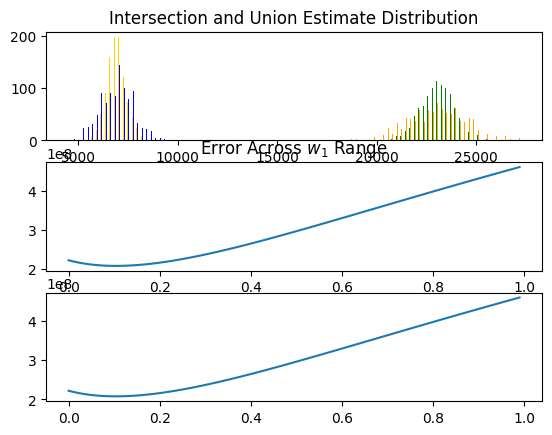

expected weights (0.1875, 0.8125)


In [244]:
# We represent sets over a finite universe of size N as vectors in R^N 
# Map a set S to a vector v having v_i = 1 if i is in S and 0 otherwise.
# in general these are distributions and can have other values.
# The usual inner product and norm apply, and disjoint sets are orthogonal under this scheme.
# also note that n(v) = sum(v_i) is a linear function of v (count, and count below a hash threshold theta, are linear)
# 
# R1---------->R1+R2
# A  --
# |    -- C = w1*R1 + w2*R2
# |     /-- 
# |   /    --
# | /        --
# I ---------->R2
# When both sets are represented as vectors in R^n we can write S1 = I + R1 and S2 = I + R2, with I, R1 and R2 all orthogonal
# the simplex between R1 and R2 is the hypotenuse of a right triangle, so the closest point C to I is the altitude.
# weights w1,w2 obtain from algebra.
# similarly the union is offset from I by R1 + R2, and the closest point is the altitude from the same hypotenuse to R1+R2
# (ie symmetry means union weights are simply the intersection weights swapped).
#
#------------------------------
# ix_skew finds weights which place w1*S1+w2*S2 closest to I and calculates the skew using those weights
# it uses the geometrical relationships above to combine linear functions of the vectors, namely n1/n2 and n1_theta/n2_theta.
# 
# n1,n2 are exact or best-estimated input set sizes
# n*_theta are size of the subsample in each set where hash(x) < theta
# ix is the best estimate of intersection size
# output is a weighted estimate of skew in the intersection (weighting maximizes contribution of intersection vs. "noise")
# skew is defined as (size of whole set)/(size of subsample where hash(x) < theta)
# todo: metrics other than size may also apply (eg estimate sum of metric m over the intersection)
def ix_weights(n1,n2,ix_full):
    w1,w2 = n2-ix_full, n1-ix_full
    norm = w1+w2 
    return w1/norm, w2/norm

def ix_skew(n1, n2, n1_theta, n2_theta, ix_full, ix_theta):
    w1,w2 = ix_weights(n1_theta,n2_theta,ix_theta)

    denom = w1*n1_theta+w2*n2_theta

    w1,w2 = ix_weights(n1,n2,ix_full)

    if denom != 0:
        skew=(w1*n1+w2*n2)/denom
    else:
        skew = 1
    return skew    

# union skew reverses weights to find skew from point closest to I + R1 + R2
# todo: use union size
def un_skew(n1, n2, n1_theta, n2_theta, ix, ix_theta):
    w2, w1 = ix_weights(n1_theta,n2_theta,ix_theta)

    denom = w1*n1_theta+w2*n2_theta

    w2, w1 = ix_weights(n1,n2,ix)

    if denom != 0:
        skew=(w1*n1+w2*n2)/denom
    else:
        skew = 1
    return skew    


# Numerical tests
# simple, exact n method theta resample
# 2 sets sizes n1 n2, resampled to theta, intersection size given
# skew correction vs. simple estimate
# multiple trials of resample with different seeds to get variances
n1 = 20000 # theta1 0.01
n2 = 10000 # theta2 
n_ix = 7000
n_un = n1+n2-n_ix
theta=0.01
ntrials = 1000

ix = list(range(0,n_ix))
s1 = list.copy(ix)
s2 = list.copy(ix)

r1=list(range(n_ix, n1))
r2=list(range(n1, n1+n2-n_ix))

s1+=r1
s2+=r2

un=list.copy(s1)+list(range(n1, n1+n2-n_ix))

print(len(s1), len(s2), len(set(s1) & set(s2)), len(un), theta)

vars_simple=list()
vars_corrected= list()
vars_un_simple=list()
vars_un_corr=list()
vars_un_diff=list()

# try all possible weights and calculate error
nweights = 100
werrs=np.zeros(nweights)
uerrs=np.zeros(nweights)
    
skewtot = 0
# loop to get variance
for i in range(0,ntrials):
    seed = Hash.generate_seed()
    h = Hash(seed)
    
    n1_theta = h.sample_count(s1,theta)
    n2_theta = h.sample_count(s2,theta)
        
    # get sampled count directly from ix instead of performing intersection of samples (same value)
    n_ix_theta = h.sample_count(ix,theta)
    
    ix_est_simple = n_ix_theta/theta
    vars_simple.append(ix_est_simple)

    # numerator from exact n's and ix
    skew = ix_skew(n1, n2, 
                   n1_theta/theta, n2_theta/theta, 
                   ix_est_simple, n_ix_theta/theta)
    
    skewtot+=skew
    ix_est_ww=skew*ix_est_simple
    vars_corrected.append(ix_est_ww)

   # all possible weights
    for w in range(0,nweights):
        w1=w/nweights
        w2=1-w1
        denom = w1*n1_theta + w2*n2_theta
        sk= (w1*n1+w2*n2)/denom
        est=sk*n_ix_theta
        err=(est-n_ix)**2
        werrs[w]+=err
        #uest=(w2*n1+w1*n2)*n_un_theta/(w2*n1_theta+w1*n2_theta)
        uest=n1+n2-est
        uerrs[w]+=(uest-n_un)**2
     
    n_un_theta = h.sample_count(un,theta)
    un_est_simple = n_un_theta/theta
    vars_un_simple.append(un_est_simple)
    skewu = un_skew(n1, n2, n1_theta, n2_theta, ix_est_simple, n_ix_theta)
        
    un_est_weighted=skewu*n_un_theta
    vars_un_corr.append(un_est_weighted)
    vars_un_diff.append(n1+n2-ix_est_ww)
 
print("avg correction", skewtot/ntrials)
print("simple var ", statistics.variance(vars_simple))
print("corrected2 var ", statistics.variance(vars_corrected))

print("union theta var ", statistics.variance(vars_un_simple))
print("union corrected var ", statistics.variance(vars_un_corr))
print("union diff var ", statistics.variance(vars_un_diff))

err2_simple = list(map(lambda x: (x-n_ix)**2, vars_simple))
err2_corr2 = list(map(lambda x: (x-n_ix)**2, vars_corrected))

print("simple rms error:", statistics.mean(err2_simple)**.5)
#print("corrected rms error:", statistics.mean(err2_corr)**.5)
print("corrected rms err2:", statistics.mean(err2_corr2)**.5)

fig,(plt1,plt2,plt3)=plt.subplots(nrows=3,ncols=1)
plt1.set_title("Intersection and Union Estimate Distribution")
plt1.hist([vars_corrected, vars_simple, vars_un_corr, vars_un_simple],100, color=['gold','blue','green','orange'])
plt2.set_title("Error Across $w_1$ Range")
plt2.plot(np.linspace(0,1,nweights,endpoint=False), werrs)
plt3.plot(np.linspace(0,1,nweights,endpoint=False), uerrs)
plt.show()
print("expected weights", ix_weights(n1,n2,n_ix))
#for w in range(0,nweights):
#    print(w/nweights, werrs[w])

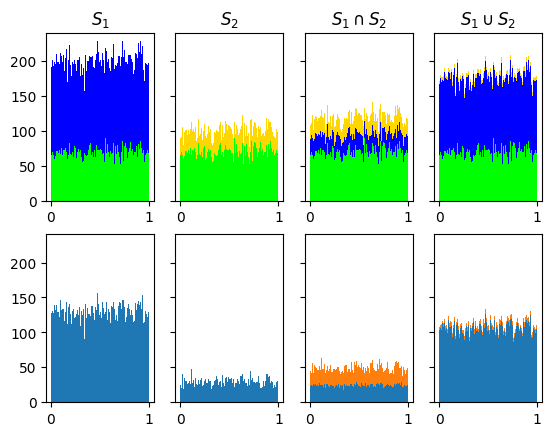

In [242]:
import matplotlib.pyplot as plt
import numpy as np
x = list(range(0,10000))
a = Hash.generate_seed()
h = Hash(a)

yi = list(map(lambda x: h.hash(x), ix))
ydiff1 = list(map(lambda x: h.hash(x),r1))
ydiff2 = list(map(lambda x: h.hash(x),r2))

#z = list(map(lambda x: random.randint(0,1000)/1000.0, x))

fig, ((plt1, plt2, plt3,plt4),(plt1b, plt2b, plt3b, plt4b)) =  plt.subplots(nrows=2, ncols=4, sharey=True)
#plt.hist(y,10000)
w1,w2=ix_weights(n1,n2,n_ix)
plt1.hist([yi, ydiff1],100, stacked=True, color=['lime','blue'])
plt1.set_title('$S_1$')
plt2.hist([yi, ydiff2],100, stacked=True, color=['lime','gold'])
plt2.set_title('$S_2$')
plt3.hist([yi,ydiff1, ydiff2],100, stacked=True, color=['lime','blue','gold'],
          weights=[np.ones(len(yi)),w1*np.ones(len(ydiff1)), w2*np.ones(len(ydiff2))])
plt3.set_title('$S_1 \cap S_2$')
plt4.hist([yi,ydiff1, ydiff2],100, stacked=True, color=['lime','blue','gold'],
          weights=[np.ones(len(yi)),w2*np.ones(len(ydiff1)), w1*np.ones(len(ydiff2))])
plt4.set_title('$S_1 \cup S_2$')
plt1b.hist([ydiff1],100, stacked=True)
plt2b.hist([ydiff2],100, stacked=True)
plt3b.hist([ydiff1, ydiff2],100, stacked=True, 
          weights=[w1*np.ones(len(ydiff1)), w2*np.ones(len(ydiff2))])
plt4b.hist([ydiff1, ydiff2],100, stacked=True, 
          weights=[w2*np.ones(len(ydiff1)), w1*np.ones(len(ydiff2))])
plt.show() 
         

47.14045207910317 33.33333333333333
[[ 47.14045208  33.33333333]
 [-47.14045208 -33.33333333]]


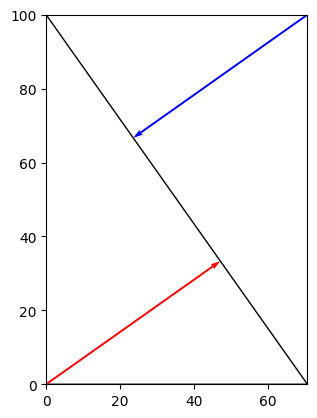

In [201]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import math

#overrides above
n1 = 20000 # theta1 0.01
n2 = 15000 # theta2 
n_ix = 10000


r1 = math.sqrt(n1-n_ix)
r2 = math.sqrt(n2-n_ix)

triangle = Polygon([(0,r1), (r2,0), (0,0),], fill=False)

w1,w2 = ix_weights(n1,n2, n_ix)
wsum = w1+w2
x=r2*w2/wsum
y=r1*w1/wsum
print(x,y)
fig, ax = plt.subplots(1,1)

V = np.array([[x,y], [-x,-y]])
origin = np.array([[0,r2],[0,r1]]) # origin point

print(V)
ax.add_patch(triangle)

plt.ylim(0,r1)
plt.xlim(0, r2)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'],
           angles='xy', scale_units='xy', scale=1)
